In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import utils as u
from models import pentzer2022 as pentzer2022
from steps import preprocess
from utils import odom_utils as odou
from visualization import papermode

# papermode(plt, size=18)


In [2]:
# Parameters
abbr = "R08"


In [3]:
preprocess(abbr, verbose=False)
powdf = pentzer2022.pentzer2022(abbr, verbose=False)


R08: 100%|██████████| 1553/1553 [00:00<00:00, 2394.25it/s]


In [4]:
print(powdf.columns.values)


['time' 'time_rel' 'vx' 'vy' 'vz' 'wz' 'current' 'voltage' 'current_cpu'
 'ax' 'ay' 'az' 'psi' 'theta' 'phi' 'qw' 'qx' 'qy' 'qz' 'cmd_v' 'cmd_w'
 'wL' 'wR' 'px' 'py' 'pz' 'I_L' 'I_R' 'V_L' 'V_R' 'lat' 'long' 'alt'
 'ax_corr' 'ay_corr' 'az_corr' 'v' 'a' 'vL' 'vR' 'Vmot_L' 'Vmot_R'
 'wmot_L' 'wmot_R' 'Imot_L' 'Imot_R' 'PE_L' 'PE_R' 'Tmot_L' 'Tmot_R' 'TL'
 'TR' 'PM_L' 'PM_R' 'P_logical' 'P_motion' 'PE_motion' 'P_total' 'PE_batt'
 'ICRx' 'ICRy' 'ICRyL' 'ICRyR' 'Bs' 'R' 'time_prop' 'normal_force'
 'dx_front' 'dx_rear' 'dy_left' 'dy_right' 'd_fl' 'd_fr' 'd_rl' 'd_rr'
 'dist_asym' 'dist_sym' 'JS_asym' 'JS_sym' 'JG' 'JB' 'm_sym' 'G_sym'
 'B_sym' 'sm_sym' 'sG_sym' 'sB_sym' 'Km_sym' 'KG_sym' 'KB_sym' 'm_asym'
 'G_asym' 'B_asym' 'sm_asym' 'sG_asym' 'sB_asym' 'Km_asym' 'KG_asym'
 'KB_asym' 'Ppredt_sym' 'Perrt_sym' 'EWMAt_sym' 'estt_sym' 'Ppredc_sym'
 'Perrc_sym' 'EWMAc_sym' 'estc_sym' 'Ppredt_asym' 'Perrt_asym'
 'EWMAt_asym' 'estt_asym' 'Ppredc_asym' 'Perrc_asym' 'EWMAc_asym'
 'estc_asym' 'energy_

In [5]:
model_name = pentzer2022.__MODEL_NAME__.lower()
basename = u.get_basename(u.get_filename(abbr))
figdir = u.get_figdir(basename, subdir=f"map-{model_name}")
model_name = pentzer2022.__MODEL_NAME__.title()

In [17]:
import pandas as pd
rundir = u.get_rundir(basename)
gps_df = pd.read_csv(rundir/f"{abbr}-DEMelevation.csv")


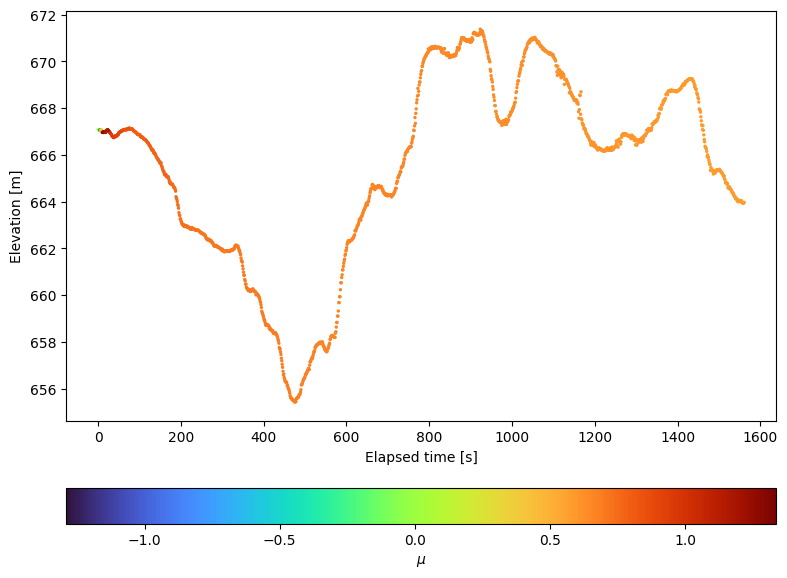

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

cseries = powdf.m_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(powdf.time_rel, gps_df.Z, c=scmap.to_rgba(cseries), s=2)
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.12, ax=ax)
cb.ax.set_xlabel("$\mu$")

ax.set_xlabel("Elapsed time [s]")
ax.set_ylabel("Elevation [m]")

fig.tight_layout()

# for ext in u.EXTS:
#     fig.savefig(figdir / f"{abbr}_perrsym_slope.{ext}", bbox_inches="tight")

In [ ]:
powdf["Ploss_L"] = powdf.PE_L - powdf.PM_L
powdf["Rloss_L"] = powdf.Ploss_L / (powdf.I_L)**2
powdf["Ploss_R"] = powdf.PE_R - powdf.PM_R
powdf["Rloss_R"] = powdf.Ploss_R / (powdf.I_R)**2

powdf["eta_L"] = powdf.PM_L / powdf.PE_L
powdf["eta_R"] = powdf.PM_R / powdf.PE_R

In [ ]:
if not "long" in powdf.columns.values:
    coords = odou.transform_odom(
        powdf.px,
        powdf.py,
        abbr=abbr
    )
else:
    coords = powdf[["long", "lat"]].copy().rename(columns={"long":"lon"})

# Cartopy

In [ ]:
import cartopy.io.img_tiles as cimgt
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


In [ ]:
tiler = cimgt.GoogleTiles(
    url="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)

fig, ax = plt.subplots(subplot_kw={"projection": tiler.crs})
gl = ax.gridlines(draw_labels=True, color="k", alpha=0.6)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# extent = [-45, -38.25, 13.25, -15]
extent = [
    coords.lon.min() - 1e-3,
    coords.lon.max() + 1e-3,
    coords.lat.min() - 1e-3,
    coords.lat.max() + 1e-3,
]

ax.set_extent(extent)
# ax.stock_img()
ax.add_image(tiler, 15)

cseries = powdf.m_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[-50:].min(),
    vmax=cseries.iloc[-50:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(coords.lon, coords.lat, c=scmap.to_rgba(cseries), s=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)
cb.ax.set_xlabel("$\mu$")
for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_msym_map.{ext}", bbox_inches="tight")


In [ ]:
tiler = cimgt.GoogleTiles(
    url="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)

fig, ax = plt.subplots(subplot_kw={"projection": tiler.crs})
gl = ax.gridlines(draw_labels=True, color="k", alpha=0.6)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# extent = [-45, -38.25, 13.25, -15]
extent = [
    coords.lon.min() - 1e-3,
    coords.lon.max() + 1e-3,
    coords.lat.min() - 1e-3,
    coords.lat.max() + 1e-3,
]

ax.set_extent(extent)
# ax.stock_img()
ax.add_image(tiler, 15)

cseries = powdf.EWMAt_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(coords.lon, coords.lat, c=scmap.to_rgba(cseries), s=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)
cb.ax.set_xlabel("EWMA of Power Estimate Error $EWMA(P_e)$")
for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_ewma_map.{ext}", bbox_inches="tight")


In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": tiler.crs})
gl = ax.gridlines(draw_labels=True, color="k", alpha=0.6)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# extent = [-45, -38.25, 13.25, -15]
extent = [
    coords.lon.min() - 1e-3,
    coords.lon.max() + 1e-3,
    coords.lat.min() - 1e-3,
    coords.lat.max() + 1e-3,
]

ax.set_extent(extent)
# ax.stock_img()
ax.add_image(tiler, 15)

cseries = powdf.Perrt_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(coords.lon, coords.lat, c=scmap.to_rgba(cseries), s=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)
cb.ax.set_xlabel("Power estimate error $P_e=P_m - P$")
for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_perrsym_map.{ext}", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

cseries = powdf.EWMAt_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(powdf.time_rel, powdf.alt, c=scmap.to_rgba(cseries), s=2)
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.12, ax=ax)
cb.ax.set_xlabel("EWMA of Power Estimation Error $EWMA(P_{err})$")

ax.set_xlabel("Elapsed time [s]")
ax.set_ylabel("Elevation [m]")

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_perrsym_slope.{ext}", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

cseries = powdf.B_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[100:800].min(),
    vmax=cseries.iloc[100:800].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(powdf.time_rel, powdf.alt, c=scmap.to_rgba(cseries), s=2)
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.12, ax=ax)
cb.ax.set_xlabel("$\\beta$")

ax.set_xlabel("Elapsed time [s]")
ax.set_ylabel("Elevation [m]")

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_bsym_slope.{ext}", bbox_inches="tight")

# DONE

In [ ]:
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(vmin=min(powdf.time_rel), vmax=max(powdf.time_rel))
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(powdf.m_sym, powdf.G_sym, c=scmap.to_rgba(powdf.time_rel))

ax.set_xlabel("${\mu}_{sym}$")
ax.set_ylabel("${G}_{sym}$")
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.2, ax=ax);
cb.ax.set_xlabel("Time [s]");

fig.suptitle(f"{abbr} - Values of $\mu$, $G$ for symmetric SSMR Gora model");

In [ ]:
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(vmin=min(powdf.time_rel), vmax=max(powdf.time_rel))
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(powdf.m_asym, powdf.G_asym, c=scmap.to_rgba(powdf.time_rel))
ax.set_xlabel("${\mu}_{asym}$")
ax.set_ylabel("${G}_{asym}$")
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.2, ax=ax);
cb.ax.set_xlabel("Time [s]");

fig.suptitle(f"{abbr} - Values of $\mu$, $G$ for asymmetric Pentzer2022 model");